In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from pathlib import Path
import statistics as st

In [25]:
# import
path = Path(kagglehub.dataset_download("ahmedabbas757/coffee-sales"))/"Coffee Shop Sales.xlsx"
records = pd.read_excel(path, index_col="transaction_id")

In [26]:
# transform
transaction_datetime = pd.to_datetime(records["transaction_date"].astype(str) + " " + records["transaction_time"].astype(str))
transaction_datetime = pd.Series(transaction_datetime, name="transaction_datetime",index=None)

records = records.reindex([
    "transaction_datetime", 'transaction_qty', 'store_id', 
    'store_location', 'product_id', 'unit_price', 
    'product_category', 'product_type', 'product_detail'], axis="columns")

records["transaction_datetime"] = transaction_datetime
records.sort_values("transaction_datetime", inplace=True)

columns = ["store_location","product_category","product_type", "product_detail"]
records[columns] = records.loc[:,columns].astype("category")

records.head()

,transaction_datetime,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
transaction_id,,,,,,,,,
1,2023-01-01 07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
2,2023-01-01 07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
3,2023-01-01 07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
4,2023-01-01 07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
5,2023-01-01 07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


store_location
Astoria            0.000067
Hell's Kitchen     0.000067
Lower Manhattan    0.000040
dtype: float64

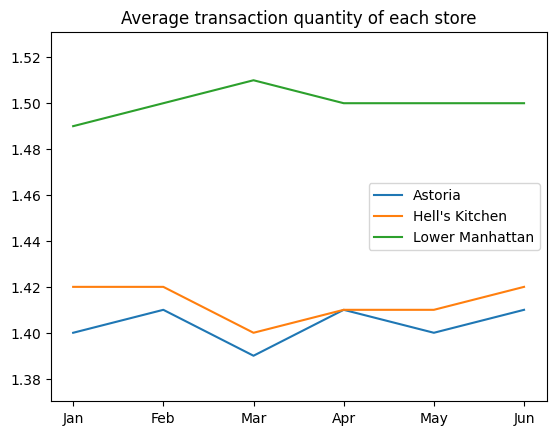

In [97]:
# How does the average monthly transaction quantity vary across different store locations, 
# and which location exhibits the highest variance in sales volume?
agg_data = (records
            .groupby(["store_location",records["transaction_datetime"].dt.month], observed=True)["transaction_qty"]
            .mean()
            .unstack()
            .round(2)
            .T
           )
agg_data.index = pd.Index(["Jan", "Feb", "Mar", "Apr", "May", "Jun"],name="month")

ax = plt.subplot()
ax.plot(agg_data, label=agg_data.columns)
ax.legend()
ax.set_ylim(ax.get_ylim()[0]*0.99,ax.get_ylim()[1]*1.01)
ax.set_title("Average transaction quantity of each store");
agg_data.agg("var")
# The transaction quantities show very little change over the months and all stay in a very small band (small variance)

In [ ]:
add